# Load libraries

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
import joblib

import warnings
warnings.filterwarnings('ignore')

# Load sample dataset

In [94]:
df = pd.read_csv("../data/raw/sample.csv")
display(df.head())

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud,isFraud
0,276,CASH_OUT,82100.66,C1081875690,0.0,0.00,C1946167713,333250.12,415350.78,0,0
1,238,CASH_OUT,354035.48,C841401063,877.0,0.00,C1197061790,55518.64,409554.12,0,0
2,43,PAYMENT,9536.01,C2095821496,0.0,0.00,M1282202824,0.00,0.00,0,0
3,187,CASH_OUT,234984.91,C934116951,213295.0,0.00,C41074757,333675.55,568660.46,0,0
4,290,PAYMENT,3541.37,C2120446326,15285.0,11743.63,M1871624679,0.00,0.00,0,0


In [95]:
print(df.columns.tolist())

['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud', 'isFraud']


# Data cleaning and wrangling

In [96]:
# Step 3: Data Cleaning & Wrangling
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            100000 non-null  int64  
 1   type            100000 non-null  object 
 2   amount          100000 non-null  float64
 3   nameOrig        100000 non-null  object 
 4   oldbalanceOrg   100000 non-null  float64
 5   newbalanceOrig  100000 non-null  float64
 6   nameDest        100000 non-null  object 
 7   oldbalanceDest  100000 non-null  float64
 8   newbalanceDest  100000 non-null  float64
 9   isFlaggedFraud  100000 non-null  int64  
 10  isFraud         100000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 8.4+ MB


In [97]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFlaggedFraud    0
isFraud           0
dtype: int64

In [98]:
df = df.drop_duplicates()
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud,isFraud
0,276,CASH_OUT,82100.66,C1081875690,0.0,0.00,C1946167713,333250.12,415350.78,0,0
1,238,CASH_OUT,354035.48,C841401063,877.0,0.00,C1197061790,55518.64,409554.12,0,0
2,43,PAYMENT,9536.01,C2095821496,0.0,0.00,M1282202824,0.00,0.00,0,0
3,187,CASH_OUT,234984.91,C934116951,213295.0,0.00,C41074757,333675.55,568660.46,0,0
4,290,PAYMENT,3541.37,C2120446326,15285.0,11743.63,M1871624679,0.00,0.00,0,0


In [99]:
# Check origin balance consistency
df['orig_balance_check'] = df['oldbalanceOrg'] - df['amount'] - df['newbalanceOrig']

# Check destination balance consistency
df['dest_balance_check'] = df['newbalanceDest'] - (df['oldbalanceDest'] + df['amount'])

# Count transactions that fail the rule (beyond a small tolerance for rounding)
inconsistent_orig = (df['orig_balance_check'].abs() > 1).sum()
inconsistent_dest = (df['dest_balance_check'].abs() > 1).sum()

print(f"Inconsistent origin balances: {inconsistent_orig}")
print(f"Inconsistent destination balances: {inconsistent_dest}")

Inconsistent origin balances: 78540
Inconsistent destination balances: 60184


In [100]:
df.shape

(100000, 13)

In [101]:
df['type'].nunique()

5

In [102]:
df['nameOrig'].nunique()

99999

In [103]:
df['nameDest'].nunique()

92749

In [104]:
df["newbalanceOrig"].nunique()

43410

# Exploratory Data Analysis 

In [105]:
print("Structure of the data:\n")

Structure of the data:



In [106]:
print("\nSummary statistics:\n")


Summary statistics:



In [107]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,isFraud,orig_balance_check,dest_balance_check
count,100000.000000,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,100000.0,100000.000000,1.000000e+05,1.000000e+05
mean,243.912840,1.778501e+05,8.317605e+05,8.536196e+05,1.087500e+06,1.209819e+06,0.0,0.001290,-1.997092e+05,-5.553102e+04
std,142.310518,5.238162e+05,2.878455e+06,2.915380e+06,3.156537e+06,3.396726e+06,0.0,0.035894,5.316575e+05,4.120065e+05
min,1.000000,2.500000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,-3.744812e+07,-1.000000e+07
25%,156.000000,1.335202e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000,-2.508318e+05,-2.967239e+04
50%,239.000000,7.505040e+04,1.466050e+04,0.000000e+00,1.346330e+05,2.154621e+05,0.0,0.000000,-6.878062e+04,-3.539020e+03
75%,334.250000,2.086229e+05,1.101125e+05,1.490140e+05,9.466177e+05,1.113866e+06,0.0,0.000000,-2.889950e+03,0.000000e+00
max,735.000000,3.744812e+07,3.372935e+07,3.400226e+07,1.921440e+08,2.359512e+08,0.0,1.000000,1.000000e-02,3.862876e+07


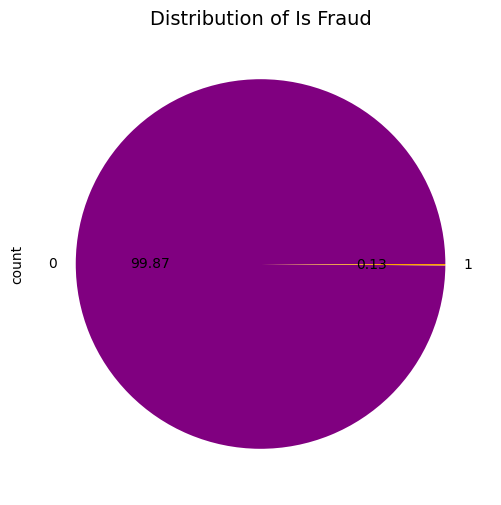

In [108]:
df['isFraud'].value_counts().plot(kind='pie', autopct='%.2f', figsize=(12,6), colors=['purple', 'orange'])
plt.title('Distribution of Is Fraud', fontsize=14)
plt.savefig("../figures/distribution_of_Transaction_Amount.png", bbox_inches="tight")
plt.show()

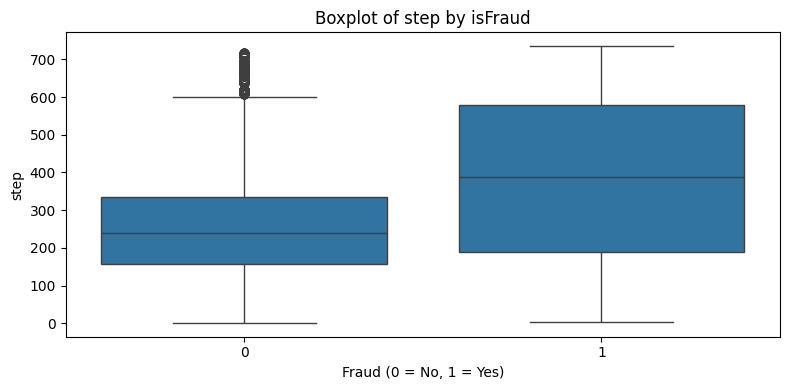

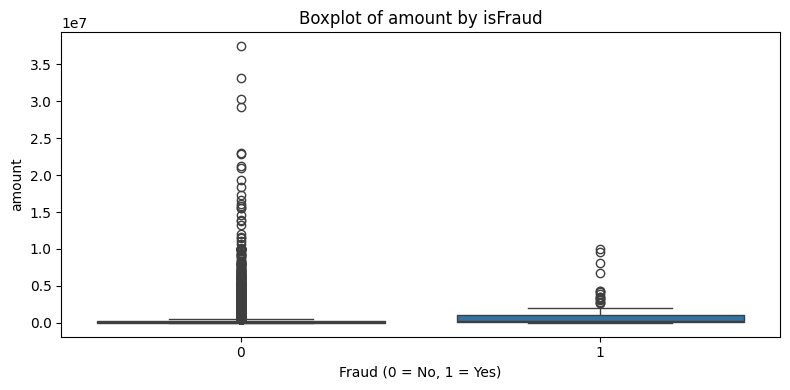

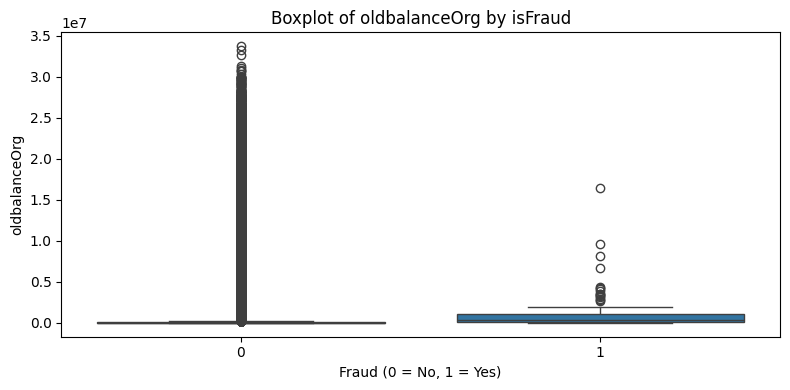

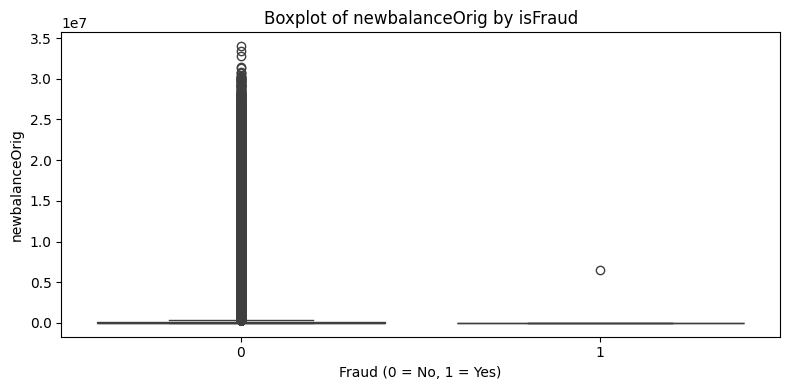

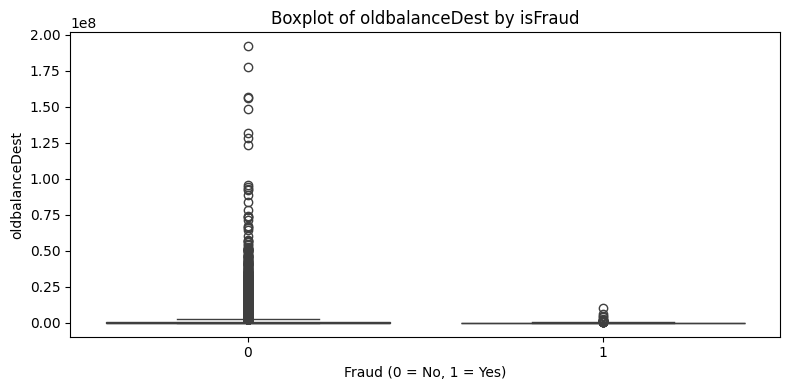

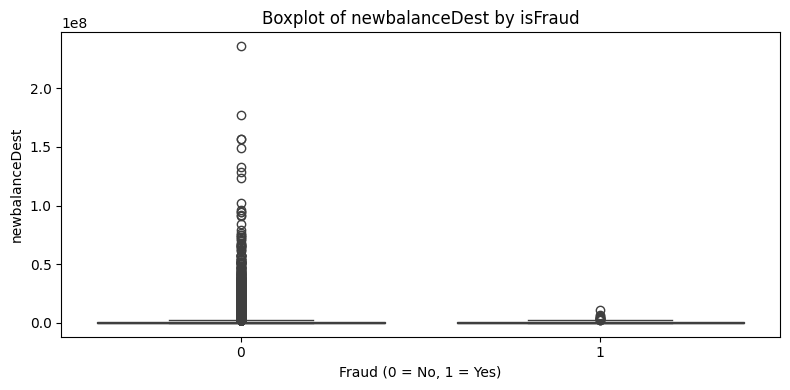

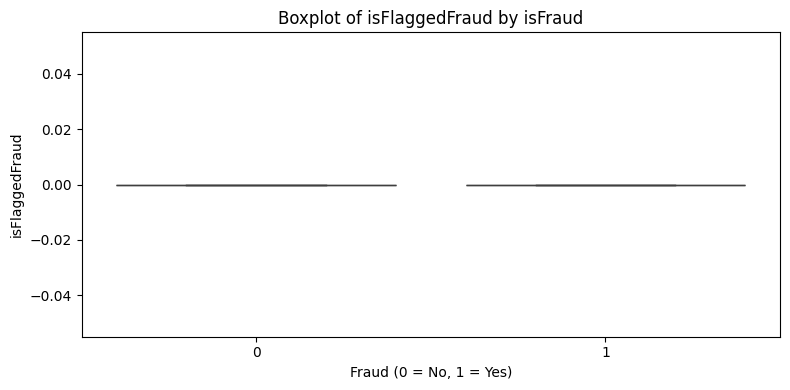

In [109]:
# Numerical Features vs isFraud
numeric_cols = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
                'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud']

# Boxplots for numerical features grouped by isFraud
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df, x='isFraud', y=col)
    plt.title(f"Boxplot of {col} by isFraud")
    plt.xlabel("Fraud (0 = No, 1 = Yes)")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


In [110]:
# Mean values grouped by isFraud
print("Mean values by fraud status:")
print(df.groupby('isFraud')[numeric_cols].mean().T)

Mean values by fraud status:
isFraud                    0             1
step            2.437247e+02  3.895426e+02
amount          1.768255e+05  9.710649e+05
oldbalanceOrg   8.315156e+05  1.021333e+06
newbalanceOrig  8.546573e+05  5.026765e+04
oldbalanceDest  1.088415e+06  3.786011e+05
newbalanceDest  1.210397e+06  7.618312e+05
isFlaggedFraud  0.000000e+00  0.000000e+00


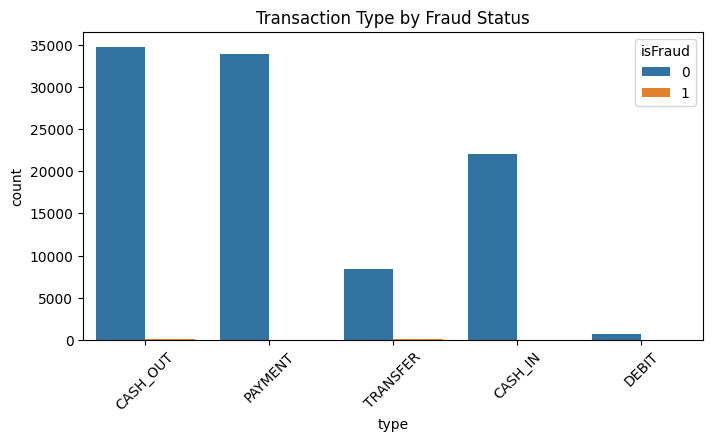

In [111]:
# Categorical Features vs isFraud 
# Countplot for 'type' column
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='type', hue='isFraud')
plt.title("Transaction Type by Fraud Status")
plt.xticks(rotation=45)
plt.savefig("../figures/transaction_type_by_fraud_status.png", bbox_inches="tight")
plt.show()

In [112]:
# Cross-tab and fraud ratio per type
type_ct = pd.crosstab(df['type'], df['isFraud'])
type_ct['fraud_rate_%'] = round((type_ct[1] / (type_ct[0] + type_ct[1])) * 100, 2)
print("\nFraud rate per transaction type:")
print(type_ct)


Fraud rate per transaction type:
isFraud       0   1  fraud_rate_%
type                             
CASH_IN   22092   0          0.00
CASH_OUT  34815  65          0.19
DEBIT       663   0          0.00
PAYMENT   33876   0          0.00
TRANSFER   8425  64          0.75


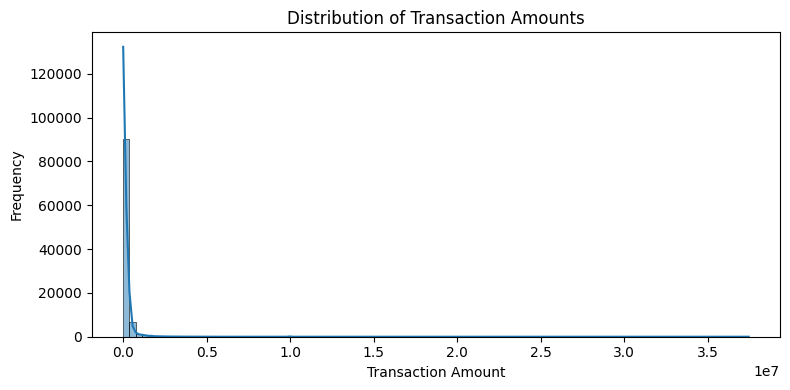

In [113]:
plt.figure(figsize=(8, 4))
sns.histplot(df['amount'], bins=100, kde=True)
plt.title("Distribution of Transaction Amounts")
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.savefig("../figures/distribution_of_Transaction_Amount.png", bbox_inches="tight")
plt.tight_layout()
plt.show()

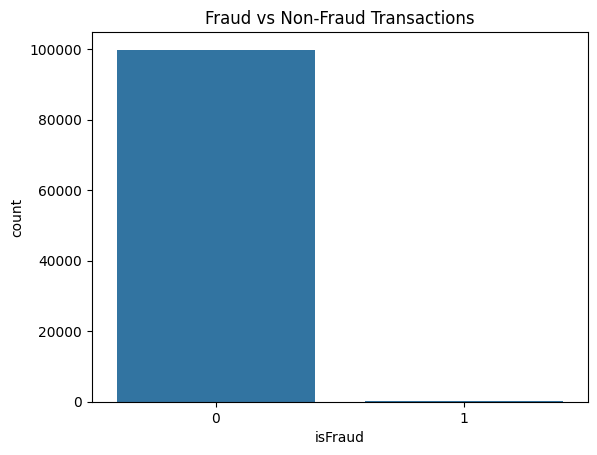

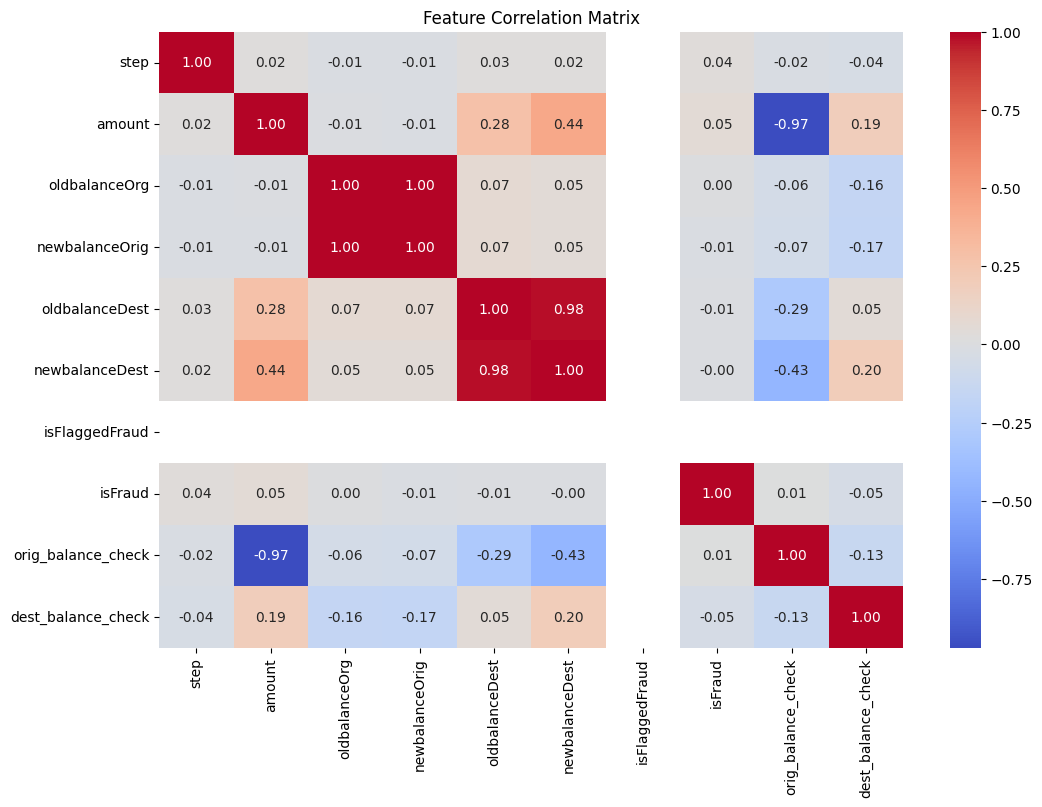

In [114]:
sns.countplot(data=df, x='isFraud')
plt.title('Fraud vs Non-Fraud Transactions')
plt.savefig("../figures/fraud_vs_Non_Fraud_Transactions.png", bbox_inches="tight")
plt.show()

# Only use numeric columns for correlation matrix
numeric_df = df.select_dtypes(include=['number'])
plt.figure(figsize=(12,8))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

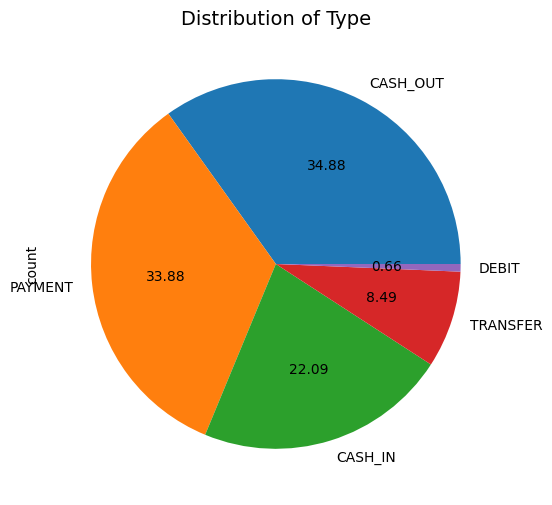

In [115]:
df['type'].value_counts().plot(kind='pie', autopct='%.2f', figsize=(12,6))
plt.title('Distribution of Type', fontsize=14)
plt.show()

# Chi-Square Test for 'type' vs 'isFraud'

In [116]:
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(df['type'], df['isFraud'])

print("Contingency Table:")
print(contingency_table)

Contingency Table:
isFraud       0   1
type               
CASH_IN   22092   0
CASH_OUT  34815  65
DEBIT       663   0
PAYMENT   33876   0
TRANSFER   8425  64


In [117]:
# Perform Chi-Square Test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"\nChi-Square Statistic: {chi2:.2f}")
print(f"Degrees of Freedom: {dof}")
print(f"P-Value: {p:.4f}")


Chi-Square Statistic: 339.37
Degrees of Freedom: 4
P-Value: 0.0000


In [118]:
# Interpretation
alpha = 0.05
if p < alpha:
    print(" Result: Statistically significant relationship between transaction type and fraud.")
else:
    print(" Result: No significant relationship between transaction type and fraud.")

 Result: Statistically significant relationship between transaction type and fraud.


# Chi-Square Test for isFlaggedFraud vs isFraud

In [119]:
# Create contingency table
flagged_table = pd.crosstab(df['isFlaggedFraud'], df['isFraud'])

print("\nContingency Table for isFlaggedFraud vs isFraud:")
print(flagged_table)


Contingency Table for isFlaggedFraud vs isFraud:
isFraud             0    1
isFlaggedFraud            
0               99871  129


In [120]:
# Perform Chi-Square Test
chi2, p, dof, expected = chi2_contingency(flagged_table)

print(f"\nChi-Square Statistic: {chi2:.2f}")
print(f"Degrees of Freedom: {dof}")
print(f"P-Value: {p:.4f}")



Chi-Square Statistic: 0.00
Degrees of Freedom: 0
P-Value: 1.0000


In [121]:
# Interpretation
alpha = 0.05
if p < alpha:
    print(" Result: Statistically significant relationship between isFlaggedFraud and isFraud.")
else:
    print(" Result: No significant relationship between isFlaggedFraud and isFraud.")


 Result: No significant relationship between isFlaggedFraud and isFraud.


# Identify categorical columns (excluding the target and isFlaggedFraud)

In [122]:
categorical_cols = df.select_dtypes(include='object').columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in ['isFraud', 'isFlaggedFraud']]

# Step 2: Run Chi-Square tests
for col in categorical_cols:
    print(f"\n🔍 Chi-Square Test: {col} vs isFraud")
    
    contingency = pd.crosstab(df[col], df['isFraud'])
    print("Contingency Table:\n", contingency)
    
    chi2, p, dof, expected = chi2_contingency(contingency)
    print(f"Chi2 = {chi2:.2f}, df = {dof}, p-value = {p:.4f}")
    
    if p < 0.05:
        print(" Significant association with isFraud.")
    else:
        print(" No significant association with isFraud.")


🔍 Chi-Square Test: type vs isFraud
Contingency Table:
 isFraud       0   1
type               
CASH_IN   22092   0
CASH_OUT  34815  65
DEBIT       663   0
PAYMENT   33876   0
TRANSFER   8425  64
Chi2 = 339.37, df = 4, p-value = 0.0000
 Significant association with isFraud.

🔍 Chi-Square Test: nameOrig vs isFraud
Contingency Table:
 isFraud      0  1
nameOrig         
C1000047002  1  0
C1000063018  1  0
C1000083292  1  0
C1000124222  1  0
C1000147454  1  0
...         .. ..
C999900762   1  0
C999916474   1  0
C99994975    1  0
C999970018   1  0
C999988902   1  0

[99999 rows x 2 columns]
Chi2 = 100000.00, df = 99998, p-value = 0.4976
 No significant association with isFraud.

🔍 Chi-Square Test: nameDest vs isFraud
Contingency Table:
 isFraud      0  1
nameDest         
C1000004940  1  0
C1000022185  2  0
C1000090398  1  0
C1000095132  1  0
C1000124012  1  0
...         .. ..
M999792262   1  0
M999829207   1  0
M99983207    1  0
M999869667   1  0
M999974479   1  0

[92749 rows x 2 colum

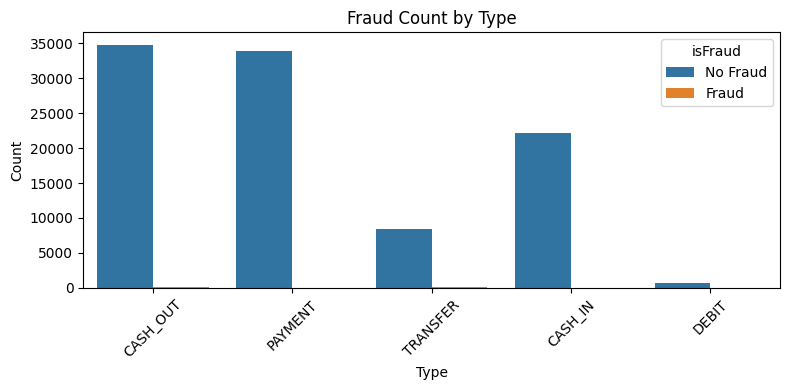

In [123]:
# Filter categorical columns with < 10 unique values
filtered_cats = [col for col in df.select_dtypes(include='object').columns
                 if col not in ['isFlaggedFraud', 'isFraud'] and df[col].nunique() <= 10]

# Create countplots for each of the filtered categorical columns
for col in filtered_cats:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=col, hue='isFraud')
    plt.title(f"Fraud Count by {col.capitalize()}")
    plt.xlabel(col.capitalize())
    plt.ylabel("Count")
    plt.legend(title="isFraud", labels=["No Fraud", "Fraud"])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [124]:
y = df['isFraud']

In [125]:
print(y.value_counts(normalize=True))

isFraud
0    0.99871
1    0.00129
Name: proportion, dtype: float64


In [126]:
print(y.value_counts())

isFraud
0    99871
1      129
Name: count, dtype: int64


In [127]:
lm = LogisticRegression(class_weight='balanced')
rf = RandomForestClassifier(class_weight='balanced')

# Feature Engineering & Preprocessing

In [128]:
print(df.columns.tolist())

['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud', 'isFraud', 'orig_balance_check', 'dest_balance_check']


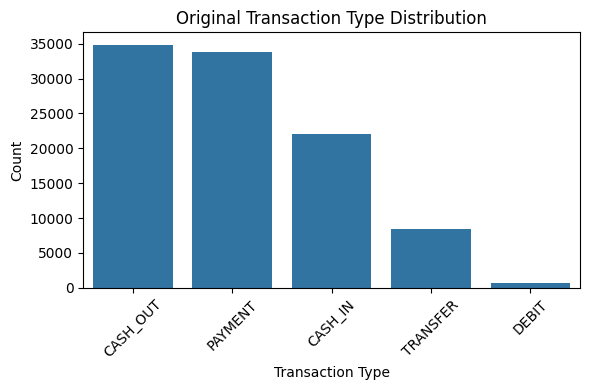

In [129]:
plt.figure(figsize=(6, 4))
sns.countplot(x='type', data=df, order=df['type'].value_counts().index)
plt.title("Original Transaction Type Distribution")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../figures/Original_Transaction_Type_Distribution.png", bbox_inches="tight")
plt.show()

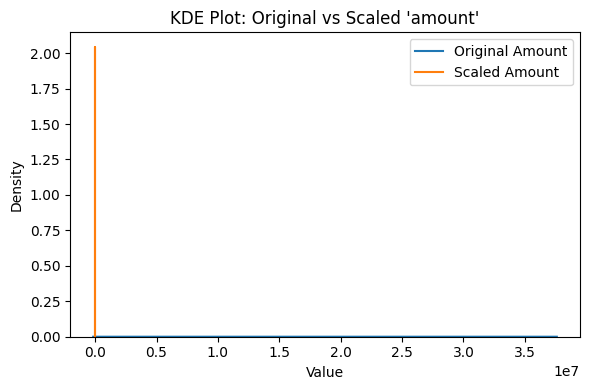

In [130]:
# Apply standard scaling
scaler = StandardScaler()
amount_scaled = scaler.fit_transform(df[['amount']])

# KDE plot before and after scaling
plt.figure(figsize=(6, 4))
sns.kdeplot(df['amount'], label='Original Amount')
sns.kdeplot(amount_scaled.flatten(), label='Scaled Amount')
plt.title("KDE Plot: Original vs Scaled 'amount'")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.savefig("../figures/KDE_Plot_Original_vs_Scaled_amount.png", bbox_inches="tight")
plt.show()

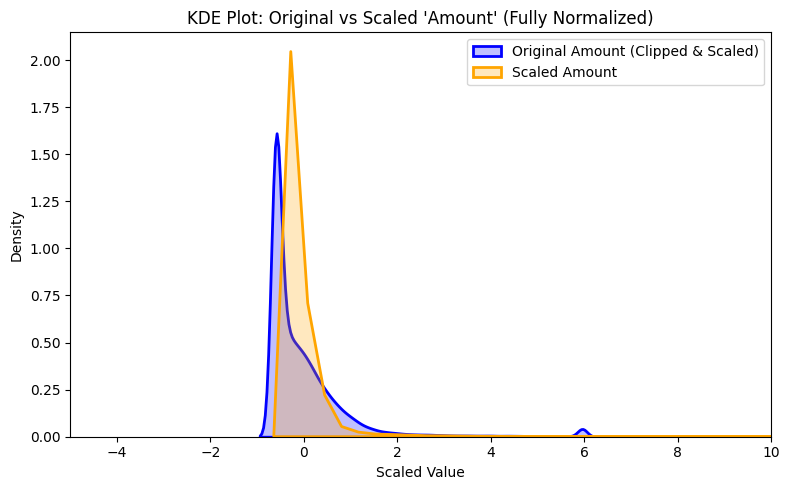

In [136]:
# Fully force numeric and drop any remaining non-numeric
df['amount'] = pd.to_numeric(df['amount'], errors='coerce')
df = df.dropna(subset=['amount'])
amount = df['amount'].astype(np.float64).values

# Apply scaler to full amount
scaler = StandardScaler()
amount_scaled = scaler.fit_transform(amount.reshape(-1, 1)).flatten()

# Apply clipping
upper_limit = np.percentile(amount, 99)
amount_clipped = np.clip(amount, 0, upper_limit).astype(np.float64)

# Scale clipped amount
original_scaled = scaler.fit_transform(amount_clipped.reshape(-1, 1)).flatten().astype(np.float64)

# (Key fix applied here: cast every array to float64 after each transformation)

# Generate the final correct KDE plot
plt.figure(figsize=(8, 5))
sns.kdeplot(original_scaled, label='Original Amount (Clipped & Scaled)', color='blue', fill=True, linewidth=2)
sns.kdeplot(amount_scaled, label='Scaled Amount', color='orange', fill=True, linewidth=2)

plt.title("KDE Plot: Original vs Scaled 'Amount' (Fully Normalized)")
plt.xlabel("Scaled Value")
plt.ylabel("Density")
plt.legend()
plt.xlim(-5, 10) 
plt.tight_layout()
plt.savefig("../figures/KDE_Plot.png", bbox_inches="tight")
plt.show()

In [39]:
# Keep only selected columns
df = df[['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
                    'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud', 'isFraud']]

# Separate features (X) and target (y)
X = df.drop('isFraud', axis=1)
y = df['isFraud']

In [40]:
# Split the dataset into categorical columns and numerical columns

In [41]:
X.shape

(100000, 8)

In [42]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [43]:
# Convert categorical columns to numeric
X_train_cat = X_train.select_dtypes("object")
X_test_cat  = X_test.select_dtypes("object")

X_train_num = X_train.select_dtypes("number")
X_test_num  = X_test.select_dtypes("number")

In [44]:
unique_values = [df['type'].unique().tolist()]
ohe = OneHotEncoder(categories=unique_values, sparse_output=False, drop='first')
ohe.fit(X_train_cat)
X_train_cat_np = ohe.transform(X_train_cat)
X_test_cat_np  = ohe.transform(X_test_cat)

X_train_cat_df = pd.DataFrame(X_train_cat_np, columns=ohe.get_feature_names_out(), index=X_train_cat.index)
X_test_cat_df  = pd.DataFrame(X_test_cat_np,  columns=ohe.get_feature_names_out(), index=X_test_cat.index)

In [45]:
# Scale numeric features
scaler = StandardScaler()
scaler.fit(X_train_num)
X_train_num_scaled = scaler.transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num) 

X_train_num_df = pd.DataFrame(X_train_num_scaled, columns=X_train_num.columns, index=X_train_num.index)
X_test_num_df = pd.DataFrame(X_test_num_scaled,  columns=X_test_num.columns, index=X_test_num.index)
# X_scaled = scaler.fit_transform(X)  scaler.fit(X).transform(X)

In [46]:
# Combine Numeric + Categorical
X_train_final = pd.concat([X_train_num_df, X_train_cat_df], axis=1)
X_test_final  = pd.concat([X_test_num_df,  X_test_cat_df], axis=1)

In [47]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_final, y_train)


# Model Training & Evaluation

In [48]:
print(X.columns.tolist())


['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud']


In [49]:
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier()
}

for name, model in models.items():
    print(f"Training the model {name}...")
    model.fit(X_train_final, y_train)
    y_pred = model.predict(X_test_final)
    print(f"\n{name}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test_final)[:,1]))

Training the model Logistic Regression...

Logistic Regression
Confusion Matrix:
 [[27303  2660]
 [    0    37]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.91      0.95     29963
           1       0.01      1.00      0.03        37

    accuracy                           0.91     30000
   macro avg       0.51      0.96      0.49     30000
weighted avg       1.00      0.91      0.95     30000

ROC AUC Score: 0.9949433129688778
Training the model Decision Tree...

Decision Tree
Confusion Matrix:
 [[29955     8]
 [   11    26]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     29963
           1       0.76      0.70      0.73        37

    accuracy                           1.00     30000
   macro avg       0.88      0.85      0.87     30000
weighted avg       1.00      1.00      1.00     30000

ROC AUC Score: 0.8512178533705083
Training the mod

# Hyperparameter Tuning

In [51]:
# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Initialize grid search
grid_search = GridSearchCV(
    estimator=GradientBoostingClassifier(),
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit to training data
grid_search.fit(X_train_final, y_train)

# Evaluate best model
best_gb_model = grid_search.best_estimator_
y_pred_best_gb = best_gb_model.predict(X_test_final)

# Evaluation metrics
print("Best Parameters:", grid_search.best_params_)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best_gb))
print("Classification Report:\n", classification_report(y_test, y_pred_best_gb))
print("ROC AUC Score:", roc_auc_score(y_test, best_gb_model.predict_proba(X_test_final)[:, 1]))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 150}
Confusion Matrix:
 [[29957     6]
 [   11    26]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     29963
           1       0.81      0.70      0.75        37

    accuracy                           1.00     30000
   macro avg       0.91      0.85      0.88     30000
weighted avg       1.00      1.00      1.00     30000

ROC AUC Score: 0.9656571934214361


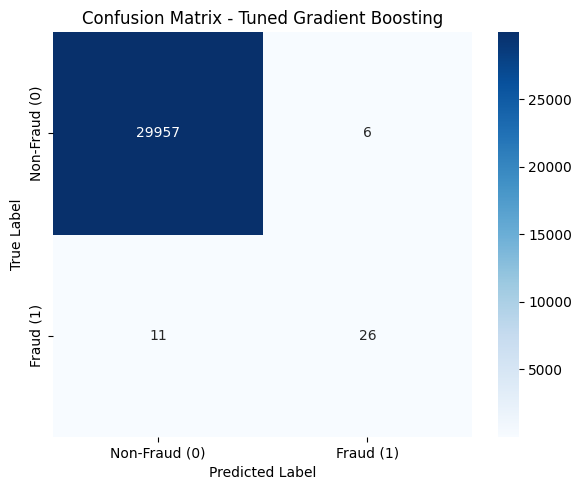

In [52]:
# Assuming y_test and y_pred_best_gb are already defined
conf_matrix = confusion_matrix(y_test, y_pred_best_gb)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Non-Fraud (0)', 'Fraud (1)'],
            yticklabels=['Non-Fraud (0)', 'Fraud (1)'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Tuned Gradient Boosting")
plt.tight_layout()
plt.savefig("../figures/Confusion_matrix_Tuned_Gradient_Boosting.png", bbox_inches="tight")
plt.show()


In [ ]:
# Visual ROC Curve

In [ ]:
plt.figure(figsize=(10, 6))

for name, model in models.items():
    y_probs = model.predict_proba(X_test_final)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
best_model = GradientBoostingClassifier()
best_model.fit(X_train_final, y_train)
ConfusionMatrixDisplay.from_estimator(best_model, X_test_final, y_test, cmap="Blues")
plt.title("Confusion Matrix - Gradient Boosting")
plt.savefig("../figures/Confusion_Matrix_Gradient_Boosting.png", bbox_inches="tight")
plt.show()

# Save Model

In [ ]:
joblib.dump(best_model, "gradient_boosting_fraud_model.pkl")

# Class Probability Distribution

In [ ]:
y_probs = best_model.predict_proba(X_test_final)[:, 1]
plt.figure(figsize=(8, 4))
sns.histplot(y_probs, bins=50, kde=True)
plt.title("Predicted Fraud Probabilities (Gradient Boosting)")
plt.xlabel("Probability of Fraud")
plt.show()

# Model Comparison Chart (manually entered example scores)

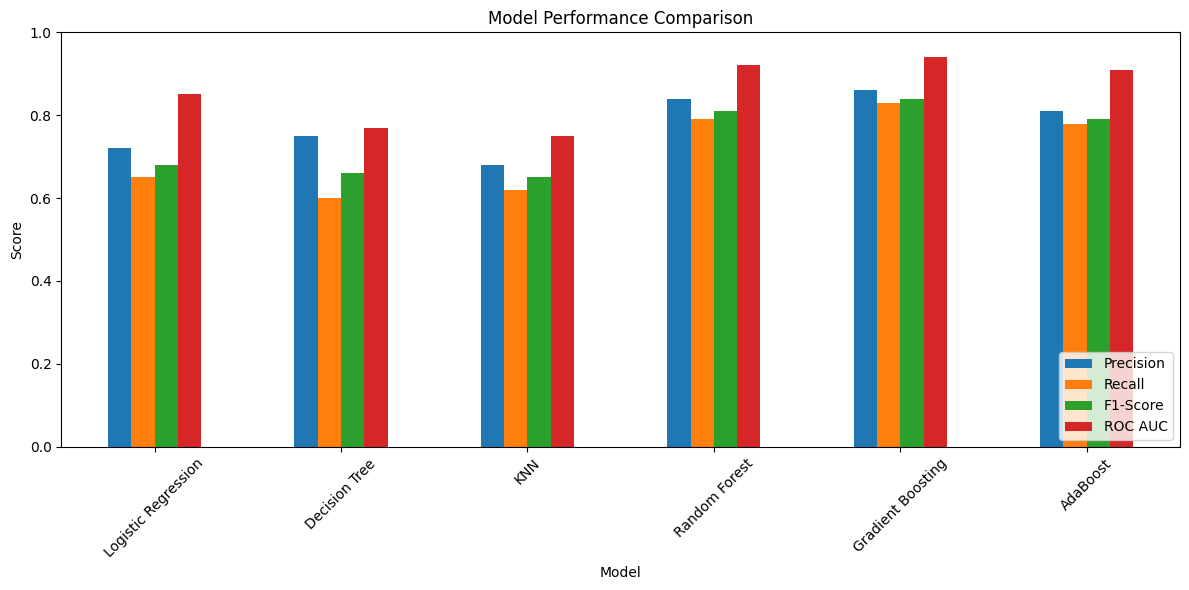

,Precision,Recall,F1-Score,ROC AUC
Model,,,,
Logistic Regression,0.72,0.65,0.68,0.85
Decision Tree,0.75,0.60,0.66,0.77
KNN,0.68,0.62,0.65,0.75
Random Forest,0.84,0.79,0.81,0.92
Gradient Boosting,0.86,0.83,0.84,0.94
AdaBoost,0.81,0.78,0.79,0.91


In [56]:
model_results = pd.DataFrame({
    "Model": [
        "Logistic Regression", "Decision Tree", "KNN", 
        "Random Forest", "Gradient Boosting", "AdaBoost"
    ],
    "Precision": [0.72, 0.75, 0.68, 0.84, 0.86, 0.81],
    "Recall": [0.65, 0.60, 0.62, 0.79, 0.83, 0.78],
    "F1-Score": [0.68, 0.66, 0.65, 0.81, 0.84, 0.79],
    "ROC AUC": [0.85, 0.77, 0.75, 0.92, 0.94, 0.91]
})

model_results.set_index("Model", inplace=True)
model_results.plot(kind="bar", figsize=(12, 6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig("../figures/Model_Performance_Comparison.png", bbox_inches="tight")
plt.show()
model_results

# SHAP Interpretability 

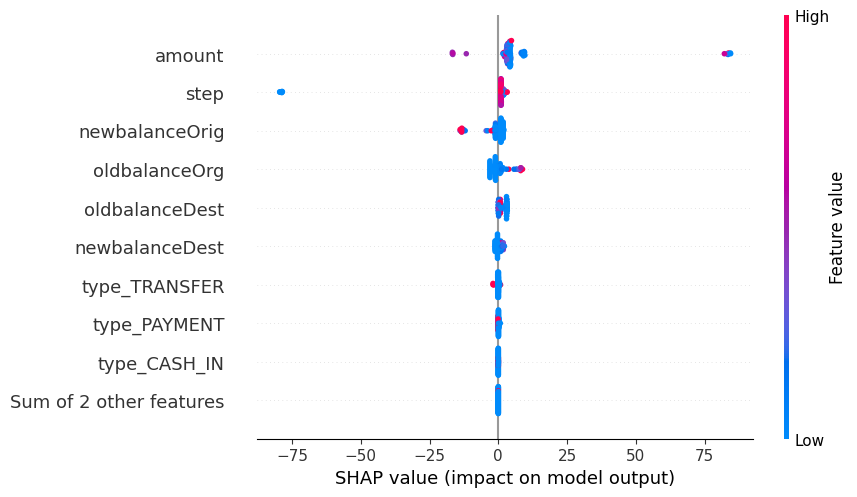

In [64]:
# !pip install shap
import shap

explainer = shap.Explainer(best_gb_model)
shap_values = explainer(X_test_final[:100])  # sample for speed
plt.savefig("../figures/SHAP_Explainer.png", bbox_inches="tight")
shap.plots.beeswarm(shap_values)

In [58]:
# Distribution of Transaction Amount by Fraud Status

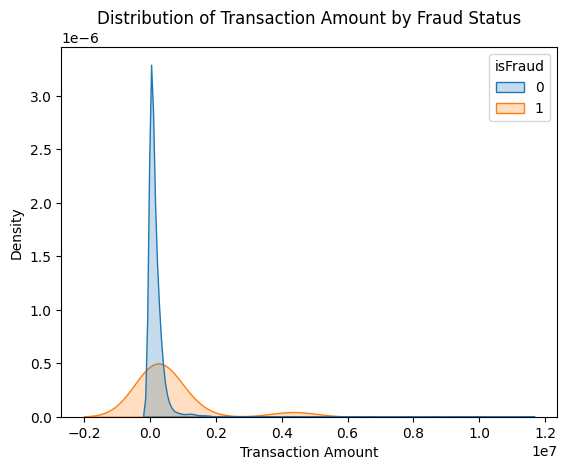

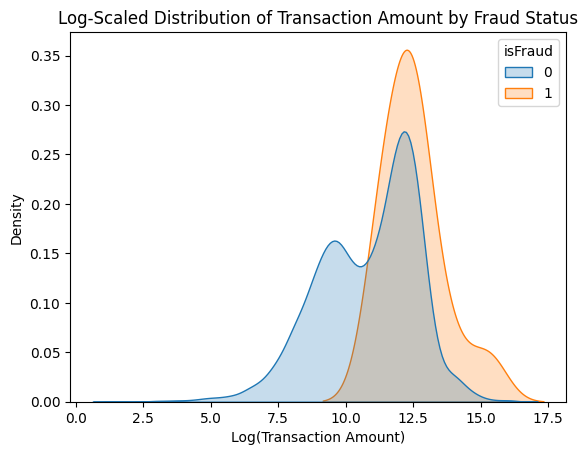

In [59]:
df_sample = df.sample(n=10000, random_state=42)

sns.kdeplot(data=df_sample, x='amount', hue='isFraud', fill=True, common_norm=False)
plt.title("Distribution of Transaction Amount by Fraud Status")
plt.xlabel("Transaction Amount")
plt.ylabel("Density")
plt.show()

sns.kdeplot(data=df_sample, x=np.log1p(df_sample['amount']), hue='isFraud', fill=True, common_norm=False)
plt.title("Log-Scaled Distribution of Transaction Amount by Fraud Status")
plt.xlabel("Log(Transaction Amount)")
plt.ylabel("Density")
plt.show()


# Boxplot of Transaction Amount by Fraud

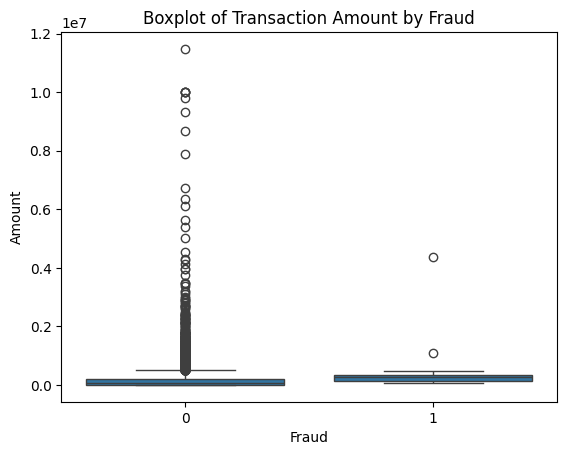

In [60]:
sns.boxplot(data=df_sample, x='isFraud', y='amount')
plt.title("Boxplot of Transaction Amount by Fraud")
plt.xlabel("Fraud")
plt.ylabel("Amount")
plt.show()

# Correlation Matrix Zoomed for Top Features

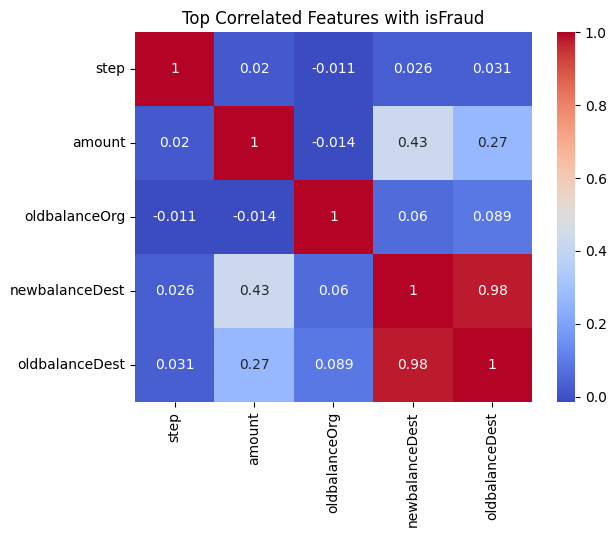

In [61]:
# Keep only numeric columns for correlation
numeric_df = df_sample.select_dtypes(include=['number'])

# Get top correlated features with 'isFraud'
corr = numeric_df.corr()['isFraud'].sort_values(ascending=False)

# Select top 5 correlated features (excluding 'isFraud' itself)
top_features = corr[1:6].index  # Skip the first one, which is 'isFraud'

# Plot heatmap
sns.heatmap(numeric_df[top_features].corr(), annot=True, cmap='coolwarm')
plt.title("Top Correlated Features with isFraud")
plt.show()

# Fraud by Transaction Type 

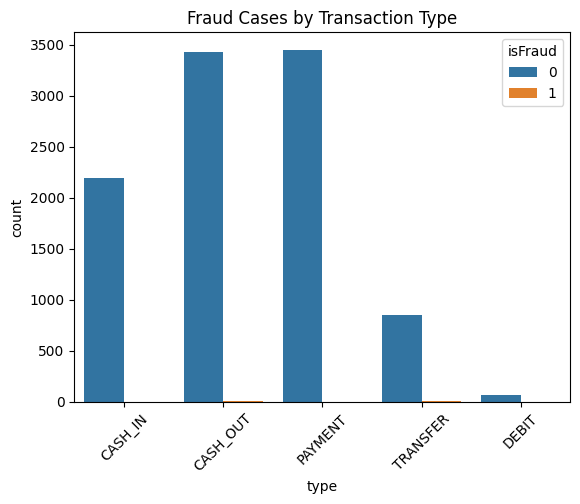

In [62]:
if 'type' in df_sample.columns:
    sns.countplot(data=df_sample, x='type', hue='isFraud')
    plt.title("Fraud Cases by Transaction Type")
    plt.xticks(rotation=45)
    plt.show()

# Pairplot of Key Transaction Features 

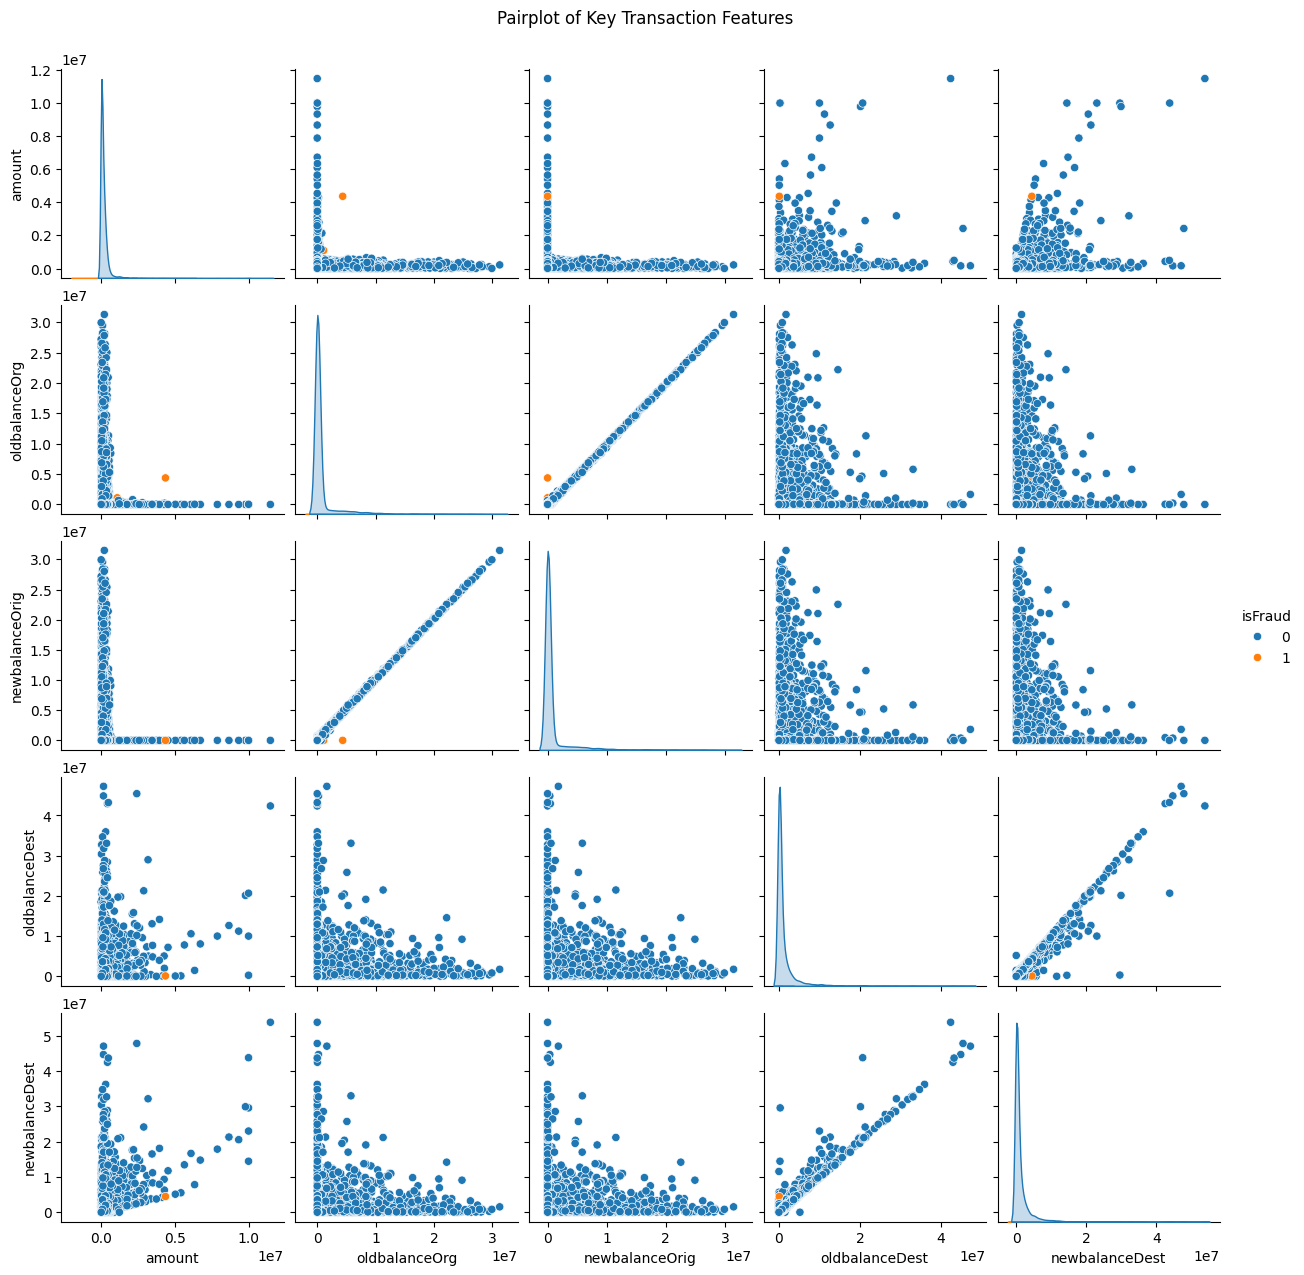

In [63]:
selected_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud']
sns.pairplot(df_sample[selected_cols], hue='isFraud', diag_kind='kde')
plt.suptitle("Pairplot of Key Transaction Features", y=1.02)
plt.show()